# **NextGen2024**: Deep Learning Workshop 1 

Within these workshops, we will dive into the learning problem, and explore what control we have as practitioners. Understand the balance and trade-offs between different variables can provide rich insight into the design and function of modern deep learning systems and directions.

We will explore this within the context of some simple models and toy datasets before moving onto explore these within the context of more modern recent architectures during our next workshop.

Through these workshops I hope to convey a better understanding of the fundamental trade-offs in the design of deep learning systems.

In [1]:
import torch
import random
import numpy as np
import torch.nn as nn
import matplotlib.pyplot as plt
from torch.utils.data import random_split

from typing import *
from torch import Tensor

# seed training (deterministic results)
random.seed(0)
np.random.seed(0)
torch.manual_seed(0)
torch.cuda.manual_seed(0)
torch.backends.cudnn.benchmark = False
torch.backends.cudnn.deterministic = True

## [Preamble] The Learning Problem

**The Hypothesis Space**: Lets refer to the set of possible models obtained from the training process as the hypothesis space $\mathcal{H}$. We'll also denote the set of possible solutions as the solution space $\mathcal{S}$.

<img src="Slide1.JPG" alt="Slide 1" width="600"/>


In machine learning, the hypothesis space $\mathcal{H}$ is typically determine by of our choice of model $\mathcal{H}_{\theta}$, data $\mathcal{H}_{D}$, and optimization $\mathcal{H}_{o}$ spaces.

<img src="Slide2.JPG" alt="Slide 2" width="600"/>


**Approximation Error**: The approximation error $\epsilon_{app}$ is the error between our target function $f$ the best possible model $h^{*} \in \mathcal{H}$. This error represents the *BEST* performance we can get out of our hypothesis space.

**Generalization Error**: The generalization error $\epsilon_{gen}$ is the error between our target function $f$ and our trained model $h \in \mathcal{H}$. This error represents the *ACTUAL* performance obtained as a result of the learning process.

**Estimation Error**: The estimation error $\epsilon_{est}$ is the difference in error between our trained model $h$ and the optimal model $h^{*}$.

<img src="Slide3.JPG" alt="Slide 3" width="600"/>

Within these workshops we will explore how the **model** and **dataset** interact and affect the design and outcome of the learning problem.

---
---
## [Section 1] Spiral Classification

Let's say we have collected some data from some physical system that produces a set of spirals, and we're interested in classifying the different spiral arms generated.

<img src="TwoSpirals.jpg" alt="Spiral" width="300"/>

Thankfully it so happens that the data generated follows a fairly simple target function $r(\theta) = \alpha + \beta * \theta + \mathcal{N}(\mu,\sigma)$, in reality with deep-learning related tasks we rarely know or can even represent this target function.

Let us see what data we've managed to collect first...

#### **Data**

We'll generate some data following this rule, and visualize the results.

In [2]:
""" Lets define our data generating process!
"""
def generateSpiralDataset(
        spiral_num_samples: int,
        spiral_noise: Optional[float] = 1., 
        spiral_revolutions: Optional[float] = 1,
    ):
        """ Lets use two simple archimedes spirals going in opposite directions using the
        following rule: radius = alpha * theta

        Returns:
            Tensor of shape [N * 3] where the columns contain [x-value, y-value, label] 

        """
        # Theta 
        theta = 2 * np.pi * spiral_revolutions * np.sqrt(np.random.rand(spiral_num_samples))

        # Spiral A
        radius_A = 2 * theta + np.pi / 2 # radius increases linearly with theta - anti-clockwise
        x_A = radius_A * np.cos(theta) # x-component
        y_A = radius_A * np.sin(theta) # y-component
        spiral_A_data = np.array([x_A, y_A]).T # pack them together: column 0 = x-values, column 1 = y-values
        spiral_A_data += spiral_noise * np.random.randn(spiral_num_samples,2) # add some noise
        spiral_A_lbls = np.zeros((spiral_num_samples,1)) # spiral A = 0
        spiral_A = np.append(spiral_A_data, spiral_A_lbls, axis=1)
            
        # Spiral B
        radius_B = -2 * theta - np.pi / 2 # clockwise
        x_B = radius_B * np.cos(theta)
        y_B = radius_B * np.sin(theta)
        spiral_B_data = np.array([x_B, y_B]).T
        spiral_B_data += spiral_noise * np.random.randn(spiral_num_samples,2) 
        spiral_B_lbls = np.ones((spiral_num_samples,1)) # spiral B = 1
        spiral_B = np.append(spiral_B_data, spiral_B_lbls, axis=1)

        # Put the data into one big array
        spirals = np.append(spiral_A, spiral_B, axis=0)
        spirals = torch.from_numpy(spirals).to(dtype=torch.float32)

        return spirals

# Generate the spiral dataset
data = generateSpiralDataset(
    spiral_num_samples = 100, 
    spiral_noise = 0.5, 
    spiral_revolutions = 1.0
)

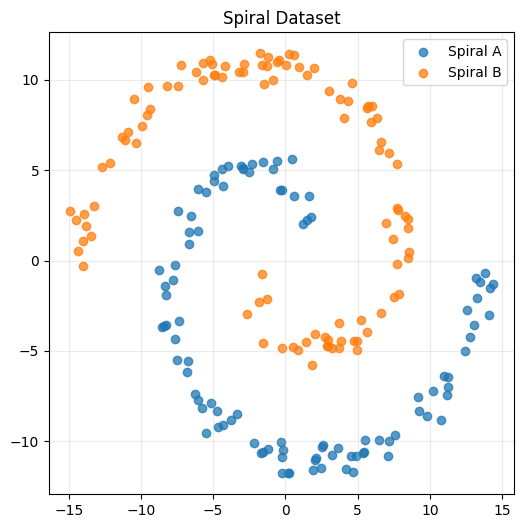

In [3]:
""" Lets plot the dataset, if possible using a color for each spiral...
""" 
# Begin by separating the dataset into the different spirals for plotting...
spiral_A_x = data[data[:,2] == 0][:,0]
spiral_A_y = data[data[:,2] == 0][:,1]
spiral_B_x = data[data[:,2] == 1][:,0]
spiral_B_y = data[data[:,2] == 1][:,1]

# Plot the results
fig = plt.figure(figsize=(6,6))
ax = fig.add_subplot(111)
ax.scatter(spiral_A_x, spiral_A_y, alpha=0.75, label="Spiral A")
ax.scatter(spiral_B_x, spiral_B_y, alpha=0.75, label="Spiral B")
ax.set_title("Spiral Dataset")
ax.grid(True, alpha=0.25)
ax.legend(loc="best")

### **Dataset**

Looks good!

We decide to split up our dataset into training and testing sets, and create a dataset to draw samples from during training.

In [4]:
""" Split up our data into training and testing!
"""
class SpiralDataset(torch.utils.data.Dataset):
    def __init__(self, data: Tensor, batch_size: Optional[int] = None):
        self.data = data
        self.batch_size = batch_size if batch_size is not None else self.data.shape[0]

    def __len__(self) -> int:
        return self.data.shape[0] // self.batch_size

    def __iter__(self) -> Tuple[Tensor, Tensor]:
        """ Yield data from the dataset in batches.
        """ 
        n_samples = self.__len__()
        for idx in range(n_samples):
            # Extract data for current batch 
            sample = self.data[idx*self.batch_size:(idx+1)*self.batch_size]

            # Define inputs: x/y-values
            x = sample[:,0:-1]

            # Define targets: labels
            y = sample[:,-1].unsqueeze(-1)

            yield x, y


# Create a function for splitting the data and creating the datasets
def split_and_create_datasets(data: Tensor, training_fraction: Optional[float] = 0.7) -> Tuple[SpiralDataset, SpiralDataset]:
    # Define the number of samples to use during training vs. testing
    n_train = int(training_fraction * data.shape[0])
    n_test = data.shape[0] - n_train

    # Split the dataset into training/testing set
    train_idxs, valid_idxs = tuple([s.indices for s in random_split(range(data.shape[0]), [n_train, n_test])])
    train_data = data[train_idxs]
    test_data = data[valid_idxs]

    # Create datasets
    train_dataset = SpiralDataset(train_data)
    test_dataset = SpiralDataset(test_data)

    return train_dataset, test_dataset


# Split data and create datasets
train_dataset, test_dataset = split_and_create_datasets(data, training_fraction=0.7)

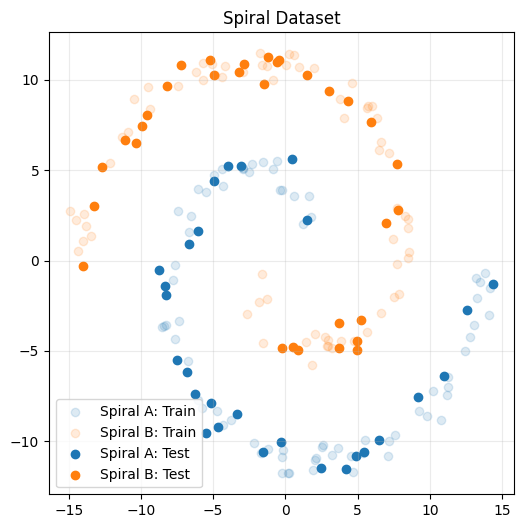

In [5]:
""" Lets plot the results
"""
# Create a function for plotting the spirals
def plot_spirals_splits(train_data, test_data):
    fig, ax = plt.subplots(figsize=(6,6))
    ax.scatter(train_data[train_data[:,2] == 0,0], train_data[train_data[:,2] == 0,1], alpha=0.15, color="tab:blue", label="Spiral A: Train")
    ax.scatter(train_data[train_data[:,2] == 1,0], train_data[train_data[:,2] == 1,1], alpha=0.15, color="tab:orange", label="Spiral B: Train")
    ax.scatter(test_data[test_data[:,2] == 0,0], test_data[test_data[:,2] == 0,1], color="tab:blue", label="Spiral A: Test")
    ax.scatter(test_data[test_data[:,2] == 1,0], test_data[test_data[:,2] == 1,1], color="tab:orange", label="Spiral B: Test")
    ax.grid(True, alpha=0.25)
    ax.set_title(f"Spiral Dataset")
    ax.legend(loc="best")


# Plot the spirals
plot_spirals_splits(train_dataset.data, test_dataset.data)

### **Model**

Being freshly minted ML practitioners we decide to take a stab at modelling this dataset using a multi-layer perceptron.

In [6]:
""" Lets define the architecture of our model!
"""
class Perceptron(nn.Module):
    """ Create a single-layer perceptron with ReLU activation function.
    """
    def __init__(self, 
        input_dim: int, 
        output_dim: int
    ):
        super(Perceptron, self).__init__()

        # Create linear layer
        # https://pytorch.org/docs/stable/generated/torch.nn.Linear.html
        self.fc = nn.Linear(input_dim, output_dim)

        # Create non-linear activation function
        # https://pytorch.org/docs/stable/generated/torch.nn.ReLU.html
        self.act = nn.ReLU()

    def forward(self, x):
        x = self.act(self.fc(x))
        return x


class MultiLayerPerceptron(nn.Module):
    """ Create a multi-layer perceptron by stacking multiple layers of perceptrons.
    """
    def __init__(self, 
        input_dim: Optional[int] = 2, 
        output_dim: Optional[int] = 1, 
        hidden_layers: Optional[int] = 0, 
        hidden_dim: Optional[int] = 4
    ):
        super(MultiLayerPerceptron, self).__init__()

        # Create input layer
        modules = [Perceptron(input_dim, hidden_dim)]

        # Create hidden layers
        for _ in range(hidden_layers):
            modules.append(Perceptron(hidden_dim, hidden_dim))

        # Create output layer
        modules.append(Perceptron(hidden_dim, output_dim))

        # Create the model
        self.layers = nn.ModuleList(modules)

    def forward(self, x):
        for layer in self.layers:
            x = layer(x)
        return x

### **Training**

We have our **dataset** and **model**, lets train up our spiral classifier.

In [7]:
""" Next we're going to create the model, optimizer, loss function we want to train!
"""
# device
device = torch.device("cuda:0") if torch.cuda.is_available() else torch.device("cpu")

# model
model = MultiLayerPerceptron(input_dim=2, output_dim=1, hidden_layers=1, hidden_dim=4).to(device)

# loss function
loss_fn = torch.nn.MSELoss() # there are better loss functions but we'll use this for now

# optimizer
opt = torch.optim.Adam(model.parameters(), lr=1e-3)

In [8]:
""" Lets train our model!
"""
from tqdm import tqdm


def train_epoch(dataset: Callable, model: Callable, loss_fn: Callable, opt: Callable):
  """ Performs a training epoch.
  """
  losses = []
  for idx, (x, y) in enumerate(dataset):
    # move data to device
    x = x.to(device)
    y = y.to(device)

    # forwards pass
    y_p = model(x)

    # compute the loss
    l = loss_fn(y_p, y)

    # performance the backwards pass (compute gradients)
    l.backward()

    # perform step of the optimizer and clear gradients
    opt.step()
    opt.zero_grad()

    # append loss
    losses.append(l.item())

  return losses, model


def test_epoch(dataset: Callable, model: Callable, loss_fn: Callable):
  """ Performs a testing epoch.
  """
  losses = []
  with torch.no_grad():
    for idx, (x, y) in enumerate(dataset):
      # move data to device
      x = x.to(device)
      y = y.to(device)

      # forwards pass
      y_p = model(x)

      # compute the loss
      l = loss_fn(y_p, y)

      # append loss
      losses.append(l.item())
    
  return losses


# Let's run the training loop!
num_epochs = 1000
train_losses = []
valid_losses = {}
train_loss, valid_loss = .0, .0
with tqdm(range(num_epochs)) as pbar:
  for epoch in pbar:
    # Training
    pbar.set_description(f"[TRAIN] Epoch: {epoch}/{num_epochs} | train loss: {train_loss:.3f} | valid loss: {valid_loss:.3f}")
    _losses, model = train_epoch(train_dataset, model, loss_fn, opt)
    train_losses += _losses
    train_loss = sum(_losses) / len(_losses)
    pbar.set_description(f"[TRAIN] Epoch: {epoch}/{num_epochs} | train loss: {train_loss:.3f} | valid loss: {valid_loss:.3f}")

    # Validation
    pbar.set_description(f"[VALID] Epoch: {epoch}/{num_epochs} | train loss: {train_loss:.3f} | valid loss: {valid_loss:.3f}")
    _losses = test_epoch(test_dataset, model, loss_fn)
    valid_losses[epoch*len(train_dataset)] = _losses[0]
    valid_loss = sum(_losses) / len(_losses)
    pbar.set_description(f"[VALID] Epoch: {epoch}/{num_epochs} | train loss: {train_loss:.3f} | valid loss: {valid_loss:.3f}")

[VALID] Epoch: 999/1000 | train loss: 0.123 | valid loss: 0.122: 100%|██████████| 1000/1000 [00:08<00:00, 111.92it/s]


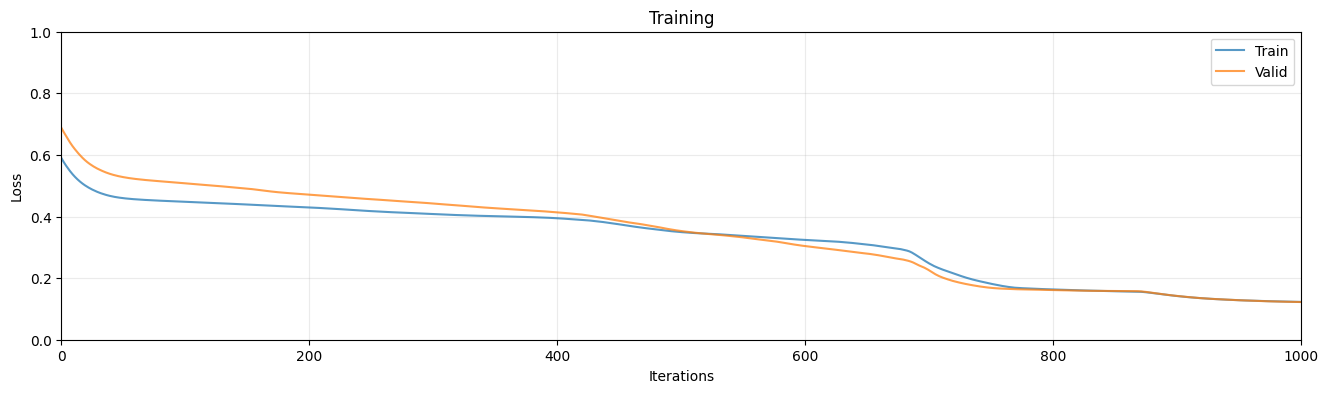

In [9]:
""" Lets plot the training performance using the losses
"""
# Plot losses from training
def plot_training_performance(train_losses, valid_losses):
  fig = plt.figure(figsize=(16,4))
  ax = fig.add_subplot(111)
  ax.plot(train_losses, linestyle="-", color="tab:blue", label="Train", alpha=0.75)
  ax.plot(valid_losses.keys(), valid_losses.values(), linestyle="-", color="tab:orange", label="Valid", alpha=0.75)
  ax.set_xlim(left=0, right=len(train_losses))
  ax.set_ylim(bottom=0, top=1)
  ax.set_xlabel("Iterations")
  ax.set_ylabel("Loss")
  ax.set_title("Training")
  ax.legend(loc="best")
  ax.grid(True, alpha=0.25)


# Plot 
plot_training_performance(train_losses, valid_losses)

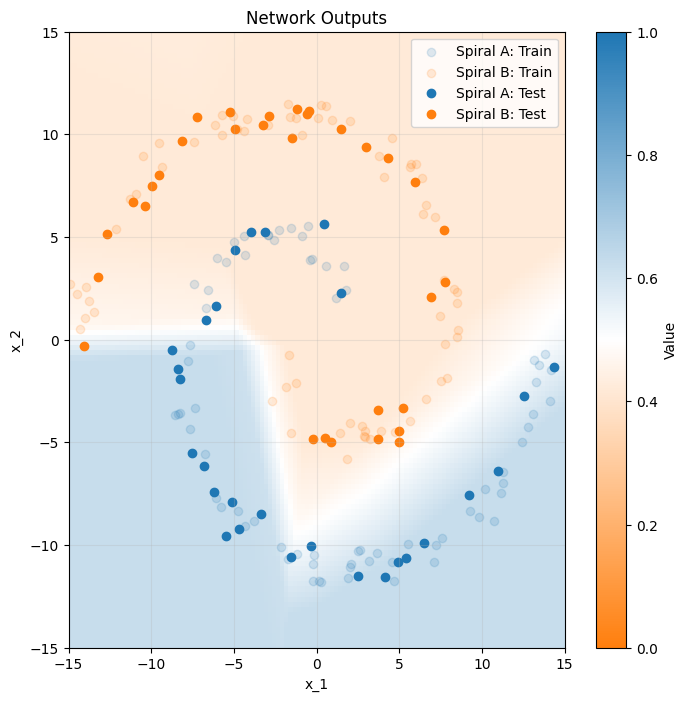

In [10]:
""" Lets also check out how the model is making decisions over the input space.
"""
def plot_model_input_space(model, train_dataset, test_dataset, x_min, x_max, x_res: Optional[int] = 120):
    # Create grid points
    X1 = np.linspace(x_min, x_max, x_res).astype(np.float32)
    X2 = np.linspace(x_min, x_max, x_res).astype(np.float32)

    # Re-order the results 
    bg = np.zeros((x_res, x_res))
    for idx, x1 in enumerate(X1):
        for jdx, x2 in enumerate(X2):
            # evaluate model at point
            point = torch.tensor([[x1, x2]])
            with torch.no_grad():
                y_p = model(point.to(device)).cpu()
            
            # store result at point
            bg[jdx, idx] = y_p.item()

    # Clip values
    bg[bg < 0] = .0
    bg[bg > 1] = 1.

    # Define normalization bounds 
    from matplotlib.colors import Normalize
    norm = Normalize(vmin=0, vmax=1)

    # Lets create a custom colorm
    from matplotlib.colors import LinearSegmentedColormap
    colors = ["tab:orange", "white", "tab:blue"]
    cmap = LinearSegmentedColormap.from_list("custom_cmap", colors)

    # Map the values to the colour map
    bg_colors = cmap(bg)[::-1,::-1]

    # Plot the results
    from matplotlib.cm import ScalarMappable
    fig = plt.figure(figsize=(8,8))
    ax = fig.add_subplot(111)
    ax.imshow(bg_colors, extent=[x_min, x_max, x_min, x_max], origin="lower", aspect="auto", alpha=0.25)
    fig.colorbar(ScalarMappable(norm=norm, cmap=cmap), ax=ax, label='Value')

    # Lets also overlay the training and testing data
    ax.scatter(train_dataset.data[train_dataset.data[:,2] == 0,0], train_dataset.data[train_dataset.data[:,2] == 0,1], alpha=0.15, color="tab:blue", label="Spiral A: Train")
    ax.scatter(train_dataset.data[train_dataset.data[:,2] == 1,0], train_dataset.data[train_dataset.data[:,2] == 1,1], alpha=0.15, color="tab:orange", label="Spiral B: Train")
    ax.scatter(test_dataset.data[test_dataset.data[:,2] == 0,0], test_dataset.data[test_dataset.data[:,2] == 0,1], color="tab:blue", label="Spiral A: Test")
    ax.scatter(test_dataset.data[test_dataset.data[:,2] == 1,0], test_dataset.data[test_dataset.data[:,2] == 1,1], color="tab:orange", label="Spiral B: Test")

    # Other figure stuff
    ax.set_title("Network Outputs")
    ax.set_xlim(left=x_min, right=x_max)
    ax.set_ylim(bottom=x_min, top=x_max)
    ax.set_xlabel("x_1")
    ax.set_ylabel("x_2")
    ax.legend(loc="best")
    ax.grid(True, alpha=0.25)


# Plot the values over the input space
plot_model_input_space(model, train_dataset, test_dataset, x_min=-15, x_max=15)

---
### **Model Bias-Complexity Trade-off**

As we increase the size and complexity of our hypothesis class $\mathcal{H}$ (i.e. creating a larger and higher capacity model), the approximation error $\epsilon_{app}$ generally *decreases* as our best possible model becomes more capable of fitting the target function $f$. 

However, the estimation error $\epsilon_{est}$ **may** also *increase* as the model becomes more capable of over-fitting the data distribution seen during training and not learning the lower dimensional rules governing the data generation process.

<img src="Slide5.JPG" alt="Slide 5" width="600"/>
<img src="Slide6.JPG" alt="Slide 6" width="600"/>

Our learning problem has a fixed complexity, we need to find the balance between under-fitting and over-fitting the training distribution.

[VALID] Epoch: 999/1000 | train loss: 0.003 | valid loss: 0.006: 100%|██████████| 1000/1000 [00:08<00:00, 112.99it/s]


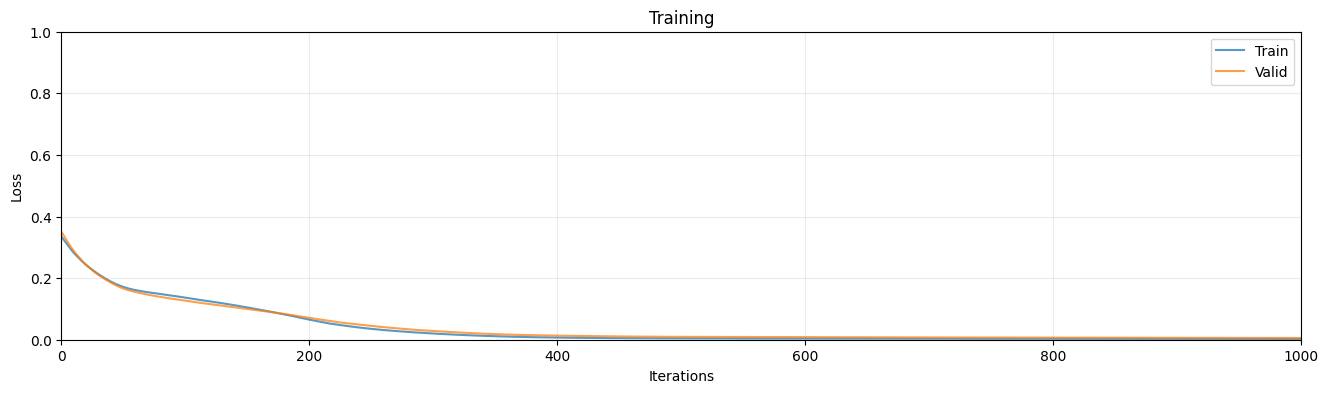

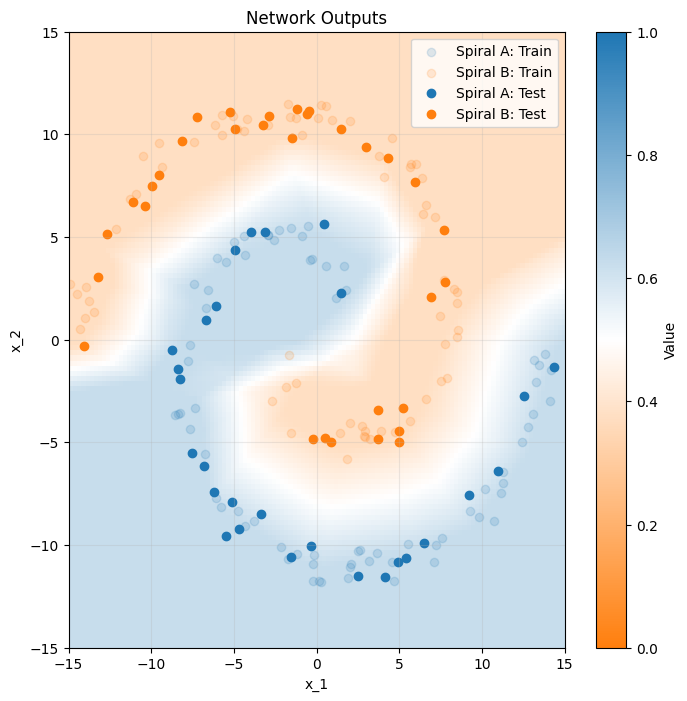

In [11]:
# Define the model, loss and optimizer
model = MultiLayerPerceptron(
  input_dim = 2,
  output_dim = 1,
  hidden_layers = 2,
  hidden_dim = 8
).to(device)
loss_fn = torch.nn.MSELoss()
opt = torch.optim.Adam(model.parameters(), lr=1e-3)

# Let's run the training loop!
num_epochs = 1000
train_losses = []
valid_losses = {}
train_loss, valid_loss = .0, .0
with tqdm(range(num_epochs)) as pbar:
  for epoch in pbar:
    # Training
    pbar.set_description(f"[TRAIN] Epoch: {epoch}/{num_epochs} | train loss: {train_loss:.3f} | valid loss: {valid_loss:.3f}")
    _losses, model = train_epoch(train_dataset, model, loss_fn, opt)
    train_losses += _losses
    train_loss = sum(_losses) / len(_losses)
    pbar.set_description(f"[TRAIN] Epoch: {epoch}/{num_epochs} | train loss: {train_loss:.3f} | valid loss: {valid_loss:.3f}")

    # Validation
    pbar.set_description(f"[VALID] Epoch: {epoch}/{num_epochs} | train loss: {train_loss:.3f} | valid loss: {valid_loss:.3f}")
    _losses = test_epoch(test_dataset, model, loss_fn)
    valid_losses[epoch*len(train_dataset)] = _losses[0]
    valid_loss = sum(_losses) / len(_losses)
    pbar.set_description(f"[VALID] Epoch: {epoch}/{num_epochs} | train loss: {train_loss:.3f} | valid loss: {valid_loss:.3f}")

# Plot the training performance
plot_training_performance(train_losses, valid_losses)

# Plot the values over the input space
plot_model_input_space(model, train_dataset, test_dataset, x_min=-15, x_max=15)

---
### **Dataset Bias-Complexity Trade-off**

However, we also have to consider the other aspects of the learning problem, the complexity of the distribution also plays a role in defining the hypothesis class $\mathcal{H}$. As we increase the size and complexity of the distribution space $\mathcal{H}_{D}$ we generally expect our approximation error $\epsilon_{app}$ to increase for a fixed model. The flip-side of this is also generally true.

Peferably, we would collect a distribution that is fully representative of the rules which govern the data generation process, however this is generally not feasible. We typically like to make sure we have a *good enough* representation with respect to the distribution we expect to see during deployment.

Say we decide to apply our model to another similar problem! Hey this binary star system has spirals, let's assume the spirals are the same as before but just extend for longer.

<img src="CelestialSpiral.jpg" alt="Spiral" width="300"/>


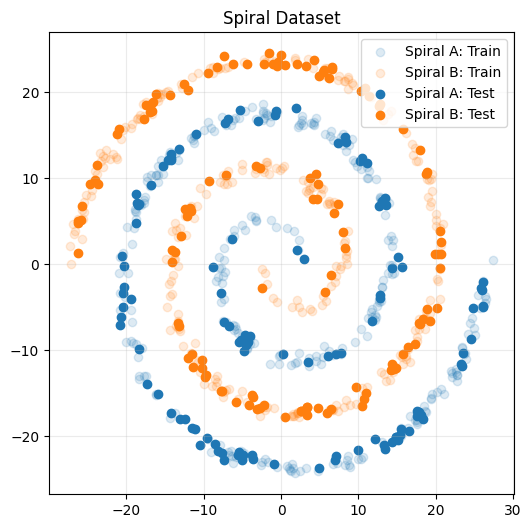

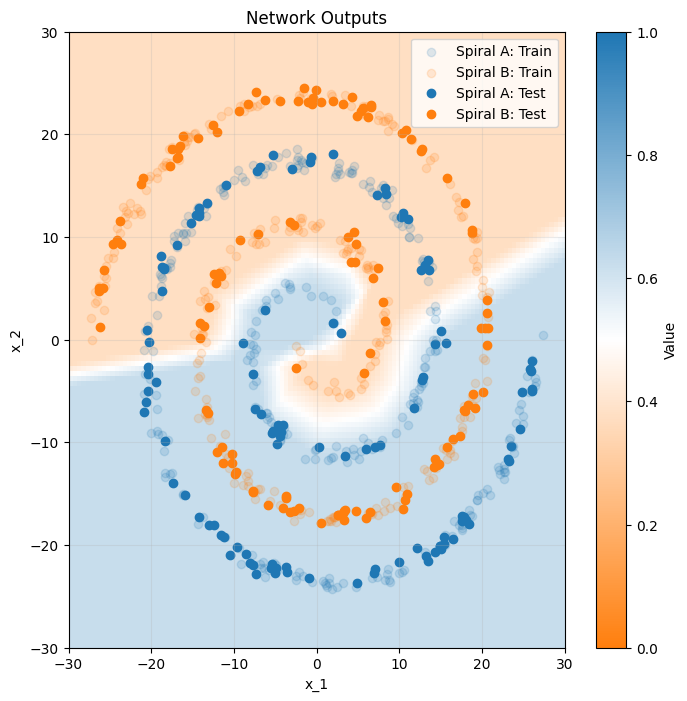

In [12]:
# Generate the spiral data : but longer...
data = generateSpiralDataset(
    spiral_num_samples = 400, 
    spiral_noise = 0.5, 
    spiral_revolutions = 2.0
)

# Create the datasets
train_dataset, test_dataset = split_and_create_datasets(data, training_fraction=0.7)

# Plot the datasets
plot_spirals_splits(train_dataset.data, test_dataset.data)

# Plot the values over the input space
plot_model_input_space(model, train_dataset, test_dataset, x_min=-30, x_max=30)

We can clearly see that the model has failed to generalize to our target function $f$, and has simply just over-fit the distribution seen during training. 

However, our model learned this problem before, potentially we just need to re-train the model...

[VALID] Epoch: 999/1000 | train loss: 0.159 | valid loss: 0.167: 100%|██████████| 1000/1000 [00:08<00:00, 112.51it/s]


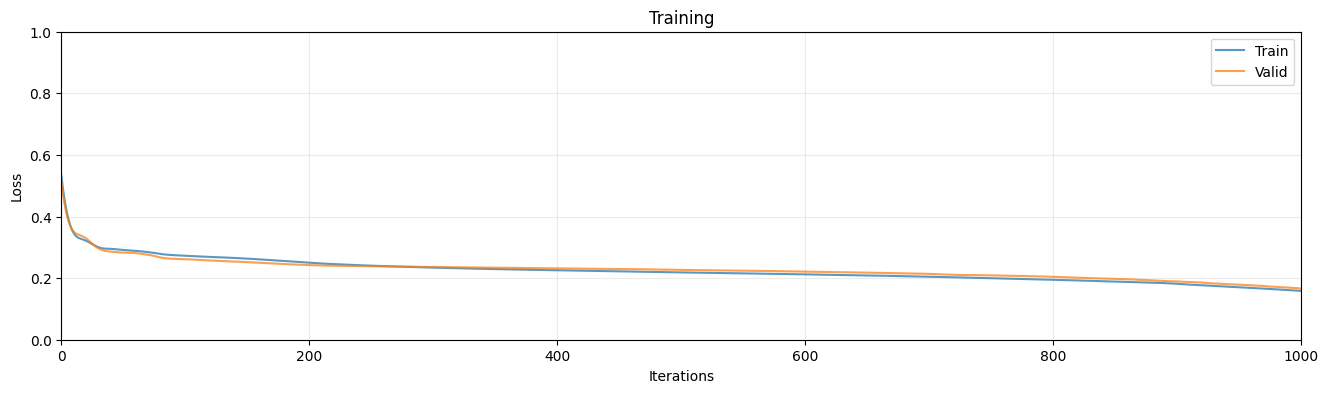

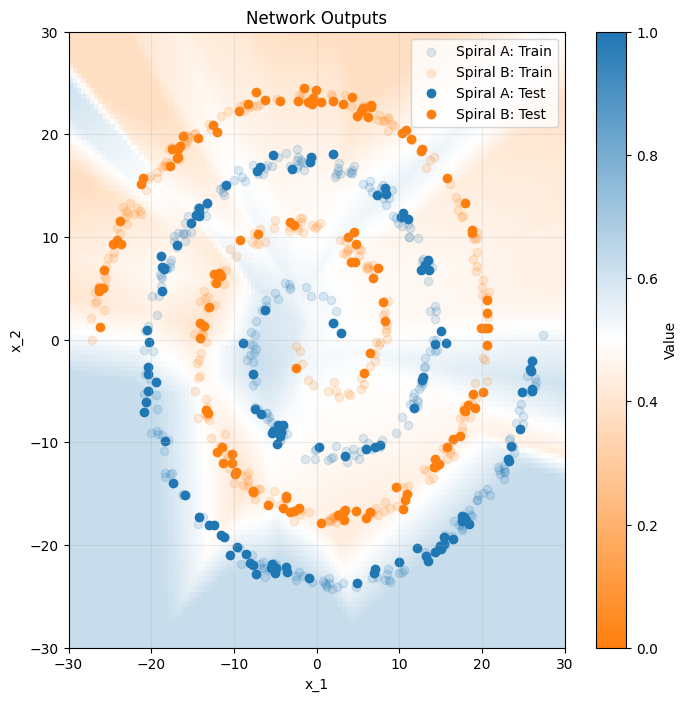

In [13]:
# Define the model, loss and optimizer
model = MultiLayerPerceptron(
    input_dim = 2,
    output_dim = 1,
    hidden_layers = 2,
    hidden_dim = 8
).to(device) #
loss_fn = torch.nn.MSELoss()
opt = torch.optim.Adam(model.parameters(), lr=1e-3)

# Let's run the training loop!
num_epochs = 1000
train_losses = []
valid_losses = {}
train_loss, valid_loss = .0, .0
with tqdm(range(num_epochs)) as pbar:
  for epoch in pbar:
    # Training
    pbar.set_description(f"[TRAIN] Epoch: {epoch}/{num_epochs} | train loss: {train_loss:.3f} | valid loss: {valid_loss:.3f}")
    _losses, model = train_epoch(train_dataset, model, loss_fn, opt)
    train_losses += _losses
    train_loss = sum(_losses) / len(_losses)
    pbar.set_description(f"[TRAIN] Epoch: {epoch}/{num_epochs} | train loss: {train_loss:.3f} | valid loss: {valid_loss:.3f}")

    # Validation
    pbar.set_description(f"[VALID] Epoch: {epoch}/{num_epochs} | train loss: {train_loss:.3f} | valid loss: {valid_loss:.3f}")
    _losses = test_epoch(test_dataset, model, loss_fn)
    valid_losses[epoch*len(train_dataset)] = _losses[0]
    valid_loss = sum(_losses) / len(_losses)
    pbar.set_description(f"[VALID] Epoch: {epoch}/{num_epochs} | train loss: {train_loss:.3f} | valid loss: {valid_loss:.3f}")

# Plot the training performance
plot_training_performance(train_losses, valid_losses)

# Plot the values over the input space
plot_model_input_space(model, train_dataset, test_dataset, x_min=-30, x_max=30)

Within this new spiral dataset we have significantly increased the size and complexity of the distribution $\mathcal{H}_{D}$, our previous model hypothesis space $\mathcal{H}_{\theta}$ was "well-balanced" for the complexity of that distribution. However, with the new learning problem our models representational capacity seems to be ill-suited to this task. 

As with before, we can increase the size and complexity of our model hypothesis space $\mathcal{H}_{\theta}$ by increasing the model size to potentially counter-act this.

[VALID] Epoch: 999/1000 | train loss: 0.038 | valid loss: 0.052: 100%|██████████| 1000/1000 [00:08<00:00, 113.50it/s]


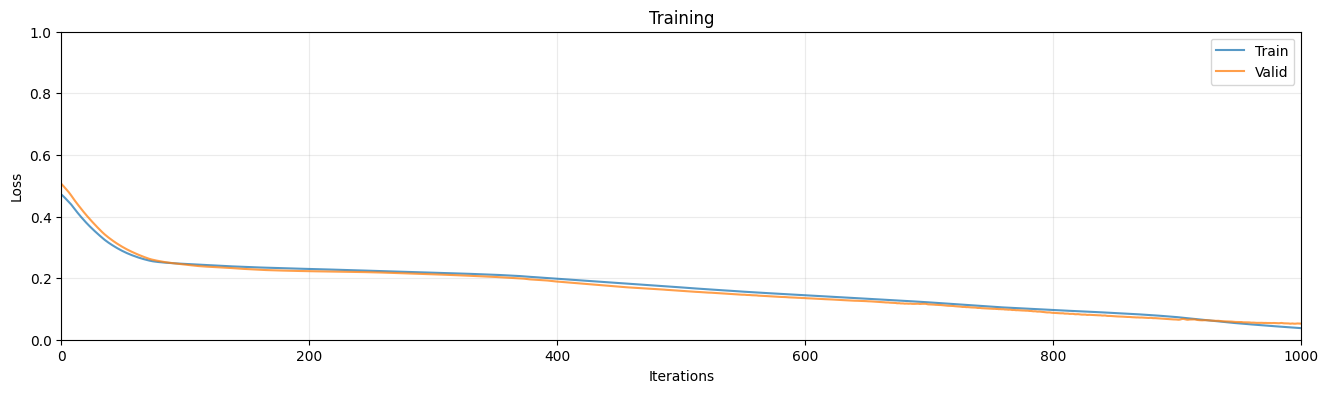

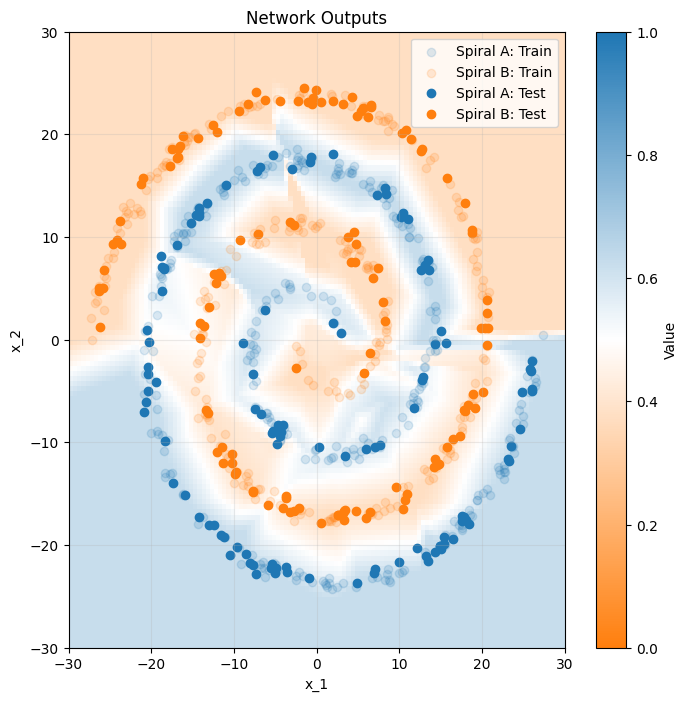

In [14]:
# Define the model, loss and optimizer
model = MultiLayerPerceptron(
    input_dim = 2,
    output_dim = 1,
    hidden_layers = 4,
    hidden_dim = 8
).to(device) #
loss_fn = torch.nn.MSELoss()
opt = torch.optim.Adam(model.parameters(), lr=1e-3)

# Let's run the training loop!
num_epochs = 1000
train_losses = []
valid_losses = {}
train_loss, valid_loss = .0, .0
with tqdm(range(num_epochs)) as pbar:
  for epoch in pbar:
    # Training
    pbar.set_description(f"[TRAIN] Epoch: {epoch}/{num_epochs} | train loss: {train_loss:.3f} | valid loss: {valid_loss:.3f}")
    _losses, model = train_epoch(train_dataset, model, loss_fn, opt)
    train_losses += _losses
    train_loss = sum(_losses) / len(_losses)
    pbar.set_description(f"[TRAIN] Epoch: {epoch}/{num_epochs} | train loss: {train_loss:.3f} | valid loss: {valid_loss:.3f}")

    # Validation
    pbar.set_description(f"[VALID] Epoch: {epoch}/{num_epochs} | train loss: {train_loss:.3f} | valid loss: {valid_loss:.3f}")
    _losses = test_epoch(test_dataset, model, loss_fn)
    valid_losses[epoch*len(train_dataset)] = _losses[0]
    valid_loss = sum(_losses) / len(_losses)
    pbar.set_description(f"[VALID] Epoch: {epoch}/{num_epochs} | train loss: {train_loss:.3f} | valid loss: {valid_loss:.3f}")

# Plot the training performance
plot_training_performance(train_losses, valid_losses)

# Plot the values over the input space
plot_model_input_space(model, train_dataset, test_dataset, x_min=-30, x_max=30)

Sometimes, we are lucky enough to be able to simply leveraging scaling laws to increase our model hypothesis space $\mathcal{H}_{\theta}$ to better capture this more complex data distribution. However this isn't always the case, sometimes certain architectures can only take us so far before we run into other limitations or issues inherent in their design... 

Understanding how the inductive biases of a model interacts with a given dataset and learning problem can provide rich insights into better ways to design models or modify the learning problem to better suit our desired outcome.

Trying to figure out a good balance between these two variables can take quite a bit of trial and error and is mostly a heuristic process based on experience and best practices. We can look at the evolution of NLP from Hidden Markov Models to LSTMS to Transformers and see this iterative development to design models to better capture and learn from larger and more complex datasets. Even just simply understanding where you sit in terms of under-fitting or over-fitting can be quite informative, there's a plethora of research into LLM scaling laws such as [Scaling Laws for Neural Language Models](https://arxiv.org/abs/2001.08361) (this paper formed the basis for OpenAI to explore scaling GPT-3 to 175B parameters) and [Training Compute-Optimal Large Language Models](https://arxiv.org/abs/2203.15556v1) are quite good in this regard to see that understanding this fundamental trade-off is an essential aspect in designing performant models.

---
### **Incorporating Priors**

We also note that if we look at the models predictions outside the domain it's clear it's still just over-fitting the training distribution and not learning the underlying data generation process.

Within the context of our toy dataset, no matter how we balance the previous factors, we will always have some approximation $\epsilon_{app}$ and thus generalization $\epsilon_{gen}$ error. For a model to learn our target function $f$ it need to be capable of representing the rules governing the data generating process $r(\theta) = \alpha + \beta * \theta + \mathcal{N}(\mu,\sigma)$. We can represent such as hypothesis space $\mathcal{H}$ as encompassing the solution space $\mathcal{S}$ and consequently $f$.

Whilst as a universal function approximator our MLP *might* be able to capture this solution, but if we look at the complexity of the model in relation to the data generation process, it would seem far more likely for it to over-fit the solution.

<img src="Slide10.JPG" alt="Slide 10" width="600"/>

Generally in designing and applying machine learning, having an understanding and intuition of the underlying symmetries of a given problem can aid in incorporating different inductive priors into the model for a given task. Building in priors can act to constraint the hypothesis space $\mathcal{H}$ allowing you to do more with less.

[VALID] Epoch: 1999/2000 | train loss: 0.002 | valid loss: 0.005: 100%|██████████| 2000/2000 [00:17<00:00, 114.57it/s]


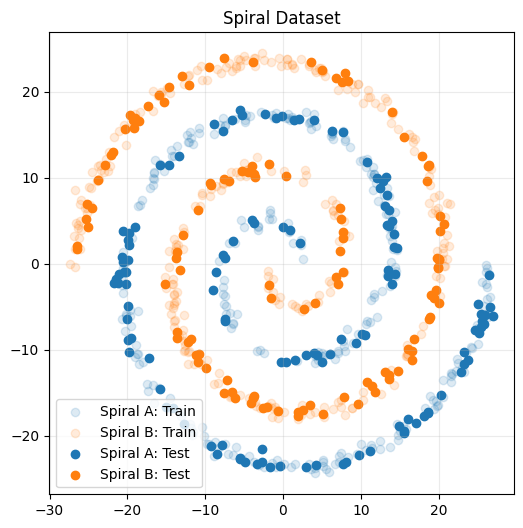

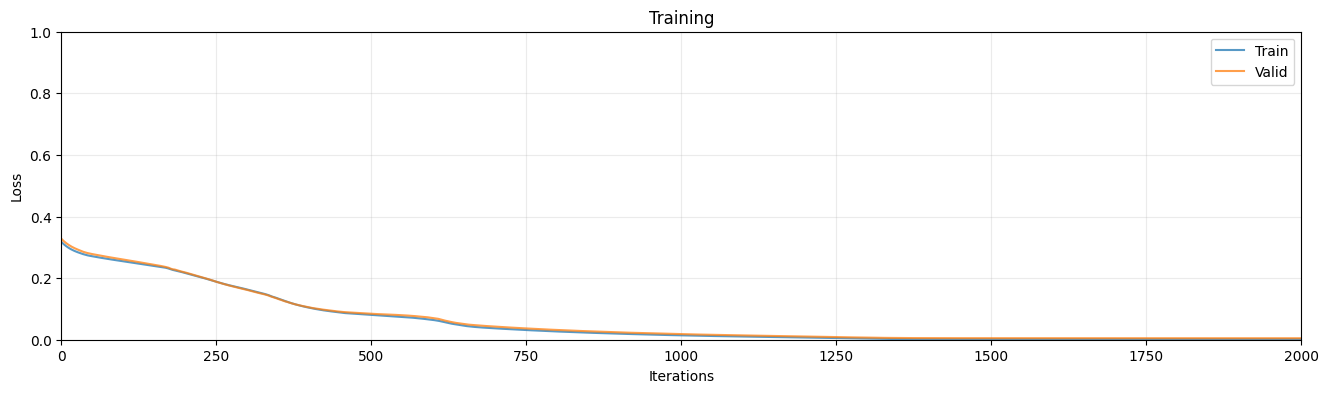

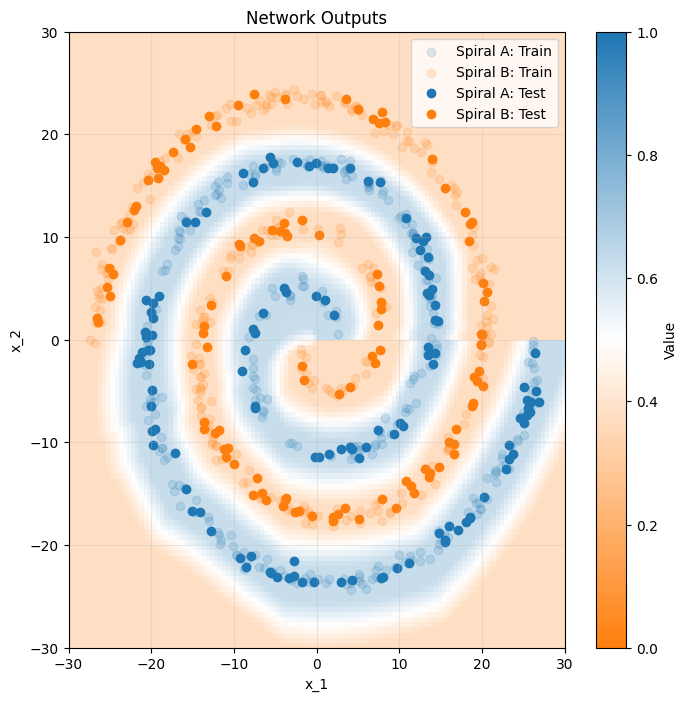

In [15]:
# Generate the spiral data..
data = generateSpiralDataset(
    spiral_num_samples = 400, 
    spiral_noise = 0.5, 
    spiral_revolutions = 2.0
)

""" Say we had some intuition that the data has a relationship with the radius at a given point... 
"""
x = data[:,0]
y = data[:,1]
lbls = data[:,2]
radius = torch.sqrt(x**2 + y**2)
theta = torch.atan2(y, x)
new_data = torch.stack([radius, theta, x, y, lbls], dim=1)

# Create the datasets
cartesian_train_dataset, cartesian_test_dataset = split_and_create_datasets(data, training_fraction=0.7)
new_train_dataset, new_test_dataset = split_and_create_datasets(new_data, training_fraction=0.7)

# Plot the datasets
plot_spirals_splits(cartesian_train_dataset.data, cartesian_test_dataset.data)

# Increase the size of the model until you see if you get slightly better performance...
model = MultiLayerPerceptron(
    input_dim = 4,
    output_dim = 1,
    hidden_layers = 4,
    hidden_dim = 8
).to(device) #
loss_fn = torch.nn.MSELoss()
opt = torch.optim.Adam(model.parameters(), lr=1e-3)

# Let's run the training loop!
num_epochs = 2000
train_losses = []
valid_losses = {}
train_loss, valid_loss = .0, .0
with tqdm(range(num_epochs)) as pbar:
  for epoch in pbar:
    # Training
    pbar.set_description(f"[TRAIN] Epoch: {epoch}/{num_epochs} | train loss: {train_loss:.3f} | valid loss: {valid_loss:.3f}")
    _losses, model = train_epoch(new_train_dataset, model, loss_fn, opt)
    train_losses += _losses
    train_loss = sum(_losses) / len(_losses)
    pbar.set_description(f"[TRAIN] Epoch: {epoch}/{num_epochs} | train loss: {train_loss:.3f} | valid loss: {valid_loss:.3f}")

    # Validation
    pbar.set_description(f"[VALID] Epoch: {epoch}/{num_epochs} | train loss: {train_loss:.3f} | valid loss: {valid_loss:.3f}")
    _losses = test_epoch(new_test_dataset, model, loss_fn)
    valid_losses[epoch*len(train_dataset)] = _losses[0]
    valid_loss = sum(_losses) / len(_losses)
    pbar.set_description(f"[VALID] Epoch: {epoch}/{num_epochs} | train loss: {train_loss:.3f} | valid loss: {valid_loss:.3f}")

# Plot the training performance
plot_training_performance(train_losses, valid_losses)


def plot_model_input_space(model, train_dataset, test_dataset, x_min, x_max, x_res: Optional[int] = 120):
    # Create grid points
    X = np.linspace(x_min, x_max, x_res).astype(np.float32)
    Y = np.linspace(x_min, x_max, x_res).astype(np.float32)

    # Re-order the results 
    import math
    bg = np.zeros((x_res, x_res))
    for idx, x in enumerate(X):
        for jdx, y in enumerate(Y):
            # evaluate model at point
            radius = math.sqrt(x**2 + y**2)
            theta = math.atan2(y, x)
            point = torch.tensor([[radius, theta, x, y]]) # NOTE: Add in the new input features

            with torch.no_grad():
                y_p = model(point.to(device)).cpu()
            
            # store result at point
            bg[jdx, idx] = y_p.item()

    # Clip values
    bg[bg < 0] = .0
    bg[bg > 1] = 1.

    # Define normalization bounds 
    from matplotlib.colors import Normalize
    norm = Normalize(vmin=0, vmax=1)

    # Lets create a custom colorm
    from matplotlib.colors import LinearSegmentedColormap
    colors = ["tab:orange", "white", "tab:blue"]
    cmap = LinearSegmentedColormap.from_list("custom_cmap", colors)

    # Map the values to the colour map
    bg_colors = cmap(bg)[::-1,::-1]

    # Plot the results
    from matplotlib.cm import ScalarMappable
    fig = plt.figure(figsize=(8,8))
    ax = fig.add_subplot(111)
    ax.imshow(bg_colors, extent=[x_min, x_max, x_min, x_max], origin="lower", aspect="auto", alpha=0.25)
    fig.colorbar(ScalarMappable(norm=norm, cmap=cmap), ax=ax, label='Value')

    # Lets also overlay the training and testing data
    ax.scatter(train_dataset.data[train_dataset.data[:,2] == 0,0], train_dataset.data[train_dataset.data[:,2] == 0,1], alpha=0.15, color="tab:blue", label="Spiral A: Train")
    ax.scatter(train_dataset.data[train_dataset.data[:,2] == 1,0], train_dataset.data[train_dataset.data[:,2] == 1,1], alpha=0.15, color="tab:orange", label="Spiral B: Train")
    ax.scatter(test_dataset.data[test_dataset.data[:,2] == 0,0], test_dataset.data[test_dataset.data[:,2] == 0,1], color="tab:blue", label="Spiral A: Test")
    ax.scatter(test_dataset.data[test_dataset.data[:,2] == 1,0], test_dataset.data[test_dataset.data[:,2] == 1,1], color="tab:orange", label="Spiral B: Test")

    # Other figure stuff
    ax.set_title("Network Outputs")
    ax.set_xlim(left=x_min, right=x_max)
    ax.set_ylim(bottom=x_min, top=x_max)
    ax.set_xlabel("x_1")
    ax.set_ylabel("x_2")
    ax.legend(loc="best")
    ax.grid(True, alpha=0.25)


# Plot the values over the input space
plot_model_input_space(model, cartesian_train_dataset, cartesian_test_dataset, x_min=-30, x_max=30)

We note that we didn't do anything particularly sophisticated or even what would generally be considered good practice, but through the "magic" of deep-learning it paid off.